<a href="https://colab.research.google.com/github/gabrielmelo00/Machine-Learning-Projects/blob/main/Spectral_and_Temporal_Modifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ***Spectral and temporal modifications Lab***


*   Gabriel Silva Vieira de Melo
*   Gabriela Barbosa Pereira
---



# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [ ]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [ ]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    _,Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [ ]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [ ]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [ ]:
IPython.display.Audio('aeiou.wav')

In [ ]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [ ]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

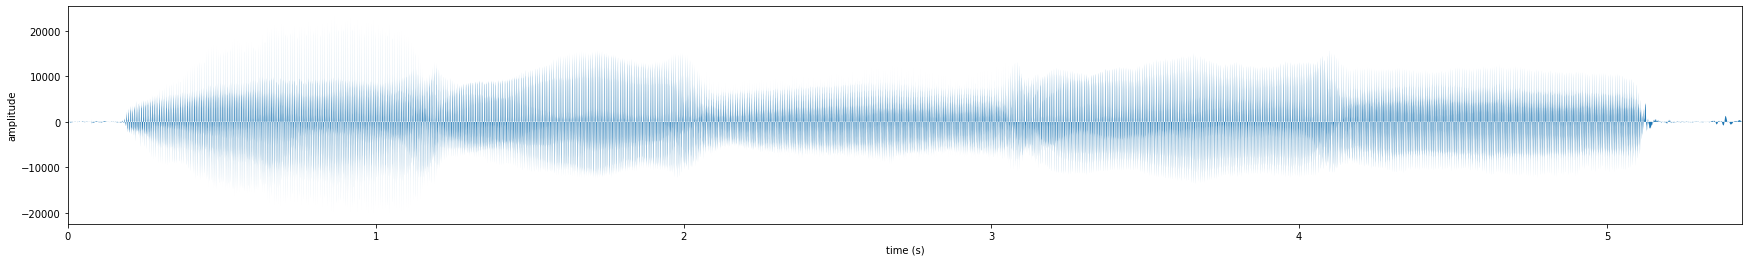

In [ ]:
plot_sound(x, times)

In [ ]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

---


# **1) Extraction of the analysis marks**

Here, we programmed a function to extract the analysis marks. To do so, we used the pitch estimator function "period". The input arguments for our function are the signal s and its sampling frequency Fs. And for the output, we will have the the time corresponding to the analysis marks, a Boolean that indicates whether the signal is voiced or not and the period expressed in number of samples in the voiced case, or equals 10ms × Fs in the unvoiced case. 

To extract the analysis marks, we followed the steps below:

*   Extraction of a sequence of duration 2.5 Pa(n-1)
*   Estimation of funtion period and computation of Pa(n) and voiced(n) 
*   Computation of Ta(n) and set new analysis mark

In [ ]:
#function that returns time corresponding to the nth marks, voiced,  pitch corresponding to the mark

def AnalysisPitchMarks(s,Fs):
  ta = []
  voiced = []
  Pa = []

  #initial conditions 
  ta.append(0)
  voiced.append(False)
  Pa.append(0.01*Fs)

  n = 1

  while(n >= 1):
    ta_0 = ta[n - 1]
    ta_1 = ta_0 + 2.5*Pa[n - 1]
    

    if(int(ta_1) < len(x)):
      voiced.append(period(s[int(ta_0):int(ta_1)], Fs)[1])
      Pa.append(period(s[int(ta_0):int(ta_1)], Fs)[0])
      ta.append(ta[n-1]+Pa[n])
      n = n + 1 
    else:
      break
  
  return np.stack((ta, voiced, Pa))

In [ ]:
A = AnalysisPitchMarks(x,Fs)
print(A)

[[    0.     110.     220.   ... 59470.   59580.   59690.  ]
 [    0.       0.       0.   ...     0.       0.       0.  ]
 [  110.25   110.     110.   ...   110.     110.     110.  ]]


In [ ]:
print(f"Number of analysis marks: {A.shape[1]}")

Number of analysis marks: 706


# **2) Synthesis and modification of the temporal and spectral scales**

First, to synthetize the signal, have to define the synthesis marks that will be
stocked in a matrix B formed of two rows, defined below.

In [ ]:
#Creating B matrix
ts_k = A[0] # B[1,:] = A[1,:]
n_k = np.arange(len(A[0])) # B[2,:] = [1, 2, 3, . . .]
B = np.stack((ts_k, n_k))

## **2.1) Signal synthesis**


To perform the signal synthesis, we programmed a synthesis function that computes the output signal y based on the analysis marks in matrix A and the synthesis marks in matrix B. 

The method consists in, firstly, extracting a window of length 2pa + 1 centered on analysis mark ta(n(k)). Then windowing it by a Hann window and finally doing an overlap-add operation.

As it can be seen and heard below, we recreated the same signal.

In [ ]:
import scipy.signal as signal

In [ ]:
def Synthesis(s,Fs,A,B):
   ts_end = B[0,-1]
   n_end = int(B[1,-1])
   Pa_end = A[2, n_end]

   y = np.zeros(int(ts_end + Pa_end))

   for k in range(len(B[1])):
     n_k = int(B[1,k])
     ta_n = A[0, n_k]
     Pa_n = A[2, n_k]
     ts_k = B[0,k]

     x = s[int(ta_n - Pa_n) : int(ta_n + Pa_n)]
     x_windowed = x*signal.hann(len(x))
     y[int(ts_k - Pa_n) : int(ts_k + Pa_n)] += x_windowed
   return y

In [ ]:
y = Synthesis(x, Fs, A, B)

In [ ]:
IPython.display.Audio(y, rate=Fs)

## **2.2) Modification of the temporal scale**

In this section, we want to determine the synthesis marks that will modify the temporal scale by a factor of $\alpha$. We will compute it by: $t_s(k)=t_s(k-1)+P_a([n(k)])$, where n(k) will be given by $n(k+1)=n(k)+\frac{1}{\alpha}$. Depending on the value of $\alpha$, the indexes will be faster or slower increased and it will change our final results. As seen below, our function was able to well perform the modification of the temporal scale, maintaining the perceived pitch of the speech segment.

In [ ]:
def ChangeTimeScale(alpha,A,Fs):
  ts_k = []
  n_k = []

  #initial conditions
  ts_k.append(1)
  n_k.append(0)
  n_k.append(1)

  k = 1
  while(k >= 1):
    if(n_k[k] < len(A[2])):
      Pa_n = A[2, int(np.floor(n_k[k]))]
      ts_k.append(ts_k[k - 1] + Pa_n)
      n_k.append(n_k[k] + (1/alpha))
      k = k + 1
    else:
      break

  return np.stack((ts_k, n_k[:-1]))

In [ ]:
B = ChangeTimeScale(0.2, A, Fs)
y = Synthesis(x, Fs, A, B)

In [ ]:
IPython.display.Audio(y, rate=Fs)

## **2.3) Modification of the spectral scale**

Now we want to determine the synthesis marks that modifies the spectral scale by a factor $\beta$. In this case, we will compute it by: $t_s(k)=t_s(k-1)+scale(k)*P_a([n(k)])$, where n(k) will be given by $n(k+1)=n(k)+scale(k)$. The scale factor will depend wether it is a voiced segment or not. If it is, $scale(k)=\frac{1}{\beta}$ and if not, it is equal to 1. Therefore, we can assume that the pitch will be changed only in the voiced marks, what we can successfully observe below.

In [ ]:
def ChangePitchScale(beta,A,Fs):
  ts_k = []
  n_k = []

  #initial conditions
  ts_k.append(1)
  n_k.append(0)
  n_k.append(1)

  k = 1
  while(k >= 1):

    if(n_k[k] < len(A[2])):
      Pa_n = A[2, int(np.floor(n_k[k]))]
      if( A[1, int(np.floor(n_k[k]))]):
        scale = 1/beta
      else:
        scale = 1

      ts_k.append(ts_k[k - 1] + Pa_n*scale)
      n_k.append(n_k[k] + scale)
      k = k + 1
    else:
      break

  return np.stack((ts_k, n_k[:-1]))

In [ ]:
B = ChangePitchScale(2, A, Fs)
y = Synthesis(x, Fs, A, B)

In [ ]:
IPython.display.Audio(y, rate=Fs)

## **2.4) Joint modification of the temporal and spectral scales**

In this part, we combined the two previous one to perform both temporal and pitch scaling, just adding some modifications in the code. Therefore, we can have different pitch and temporal combinations. The difficulties encountered were mostly related to the correct initialization, since the arrays in pyhton start from 0, and vector sizes mismatching. Still, the methods worked well and give us great results as expected on the signals proposed.

In [ ]:
def ChangeBothScales(alpha,beta,A,Fs):
  ts_k = []
  n_k = []

  #initial conditions
  ts_k.append(1)
  n_k.append(0)
  n_k.append(1)

  k = 1
  while(k >= 1):

    if(n_k[k] < len(A[2])):
      Pa_n = A[2, int(np.floor(n_k[k]))]
      if( A[1, int(np.floor(n_k[k]))]):
        scale = 1/beta
      else:
        scale = 1

      ts_k.append(ts_k[k - 1] + Pa_n*scale)
      n_k.append(n_k[k] + scale/alpha)
      k = k + 1
    else:
      break

  return np.stack((ts_k, n_k[:-1]))

In [ ]:
B = ChangeBothScales(1, 2, A, Fs)
y = Synthesis(x, Fs, A, B)
IPython.display.Audio(y, rate=Fs)

In [ ]:
B = ChangeBothScales(0.1, 1, A, Fs)
y = Synthesis(x, Fs, A, B)
IPython.display.Audio(y, rate=Fs)

In [ ]:
B = ChangeBothScales(0.1, 2, A, Fs)
y = Synthesis(x, Fs, A, B)
IPython.display.Audio(y, rate=Fs)

## **Difficulties Experienced**

The main difficulty in doing the lab was to think of a recursive algorithm to solve the exercises. As this was taking too much time from the team, we decided to use an iterative code. This decision facilitated the development of the project and the results obtained fulfilled what was being requested. 